In [1]:
%matplotlib notebook

Zebrafish: Plot the distance to source over time plot



In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
import os
import glob
import json
import math
import pickle
from scipy.ndimage.interpolation import affine_transform
from scipy.spatial.distance import cdist
from scipy import ndimage
import pandas as pd
from scipy import stats
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
# This will change to the default sans-serif font
plt.rcParams["font.family"] = "sans-serif"
# This defines that the default will be Helvetica
from pathlib import Path
import shared_functions
import statsmodels.api as sm

In [3]:
home_path = os.getcwd()
# set to True to save plots
save_plot = False

data_path = Path(home_path, 'data/gaussian_arena/')
data_path_ctr = Path(home_path, 'data/control/')
# all the figures will be saved in this folder
target_path = Path(home_path, 'plots/')
Path(target_path).mkdir(parents=True, exist_ok=True) 

In [4]:
def calculate_distance_to_source(path, control=False):
    """
    This function collects all data in a number of folders.
    
    First, it filters the x and y coordinates using the open triangle filter. 
    Then, it calculates the distance to source using these filtered coordinates.
    
    For the control experiments it calls the adjust_VR_arena_to_animal() function.
    """
    
    folders = [x for x in path.iterdir() if x.is_dir()]

    # collect all the data from all the folders in this cell
    # start by pre-allocating an array for all the source coordinates and other experiment specific data. This is necessary
    # as different experiments are often recording using a different device with slightly different pixel_mm. fps and recording 
    # time should be similar of course...
    arena_max_coordinates = np.zeros((2,len(folders)))
    arena_max_coordinates.fill(np.nan)
    pixel_per_mm = np.zeros((1, len(folders)))
    pixel_per_mm.fill(np.nan)
    fps = np.zeros((1, len(folders)),dtype=np.int)
    fps.fill(np.nan)
    
    # Go through each experimental folder, collect relevant data and calculate
    # distance to source
    for i, folder_name in enumerate(folders):
        print('Analyzing ' + folder_name.parts[-1])
        
        files = [x for x in folder_name.iterdir() if x.is_file()]

        # Read relevant data
        with open((Path(folder_name, 'experiment_settings.json')), 'r') as file:
            experiment_settings = json.load(file)
            pixel_per_mm[:,i] = experiment_settings['Pixel per mm']
            fps[:,i] = int(experiment_settings['Framerate'])
            
        data_first_frame = []
        with (open(Path(folder_name, 'first_frame_data.pkl'), 'rb')) as openfile:
            while True:
                try:
                    data_first_frame.append(pickle.load(openfile))
                except EOFError:
                    break

        if i == 0:
            temp = np.load(Path(folder_name, 'smAL-VR-centroids.npy'))
            all_centroids = np.zeros((temp.shape[0], temp.shape[1], len(folders)))
            all_centroids.fill(np.nan)
            # can calculate distance for each experiment already
            distance = np.zeros((temp.shape[0], len(folders)))
            distance.fill(np.nan)

            # preallocate the arena
            arena_VR = np.zeros((480, 640, len(folders)))
        all_centroids[:,:,i] = np.load(Path(folder_name, 'smAL-VR-centroids.npy'))
        
        # find the data_file.csv to get the distance to source of the centroid
        for file in files:
            if 'data.csv' in file.parts[-1]:
                data = pd.read_csv(file)
                
        y = np.asarray(data['Y-Centroid'])
        x = np.asarray(data['X-Centroid'])

        if i == 0:
            centroid_coordinates = np.zeros((x.shape[0],2,len(folders)))
        centroid_coordinates[:, 0, i] = y
        centroid_coordinates[:, 1, i] = x
        
        # Filter the x and y coordinates of the centroids!
        if i == 0:
            all_centroid_coordinates_filt = np.zeros((x.shape[0],2,len(folders)))

        # filter x/y coordinates using the half-triangle
        centroid_filt_y =  np.floor(np.convolve(y,shared_functions.constants.kernel_centroid,'same'))
        centroid_filt_x =  np.floor(np.convolve(x,shared_functions.constants.kernel_centroid,'same'))
        centroid_filt = np.asarray((centroid_filt_y, centroid_filt_x)).T
        
        all_centroid_coordinates_filt[:,:,i]= centroid_filt

        # In control experiments no virtual arena was saved - need to reconstruct post-hoc what the arena
        # would have looked like
        virtual_arena = None
        if control:
            # adjust the arena according to the first frame
            virtual_arena = shared_functions.adjust_VR_arena_to_animal(
                data_first_frame, 
                centroid_coordinates[:,:,i],
                home_path)
        # In experiment condition, just read the used virtual arena
        else:
            # get the arena
            for file in files:
                if 'csv' and '640x480' in file.parts[-1]:
                    virtual_arena = np.genfromtxt(file, delimiter=',')

        max_arena_indices = np.where(virtual_arena == np.amax(virtual_arena))
        # just the the first one as there are only two anyways and it's only used to center the image
        arena_max_coordinates[:,i] = max_arena_indices[0][0], max_arena_indices[1][0]
        arena_VR[:,:,i] = virtual_arena
        
        # Calculate the eucledian distance  
        for j in range(all_centroid_coordinates_filt.shape[0]):
            distance[j,i] = np.linalg.norm(all_centroid_coordinates_filt[j,:,i] \
                                           - arena_max_coordinates[:,i])\
                                           / pixel_per_mm[:,i]
 
    return(distance, fps[:,i][0], arena_VR)

In [5]:
distance_exp, fps, arena_exp = calculate_distance_to_source(data_path)

Analyzing 01.07.2018_12-24-50_Casper AB
Analyzing 01.07.2018_14-25-37_Casper AB
Analyzing 01.07.2018_14-56-01_Casper AB
Analyzing 01.07.2018_15-15-17_Casper AB
Analyzing 01.07.2018_15-21-37_Casper AB
Analyzing 01.07.2018_15-31-53_Casper AB
Analyzing 01.07.2018_15-45-35_Casper AB
Analyzing 01.07.2018_16-28-07_Casper AB
Analyzing 01.07.2018_16-38-07_Casper AB
Analyzing 01.07.2018_16-56-10_Casper AB
Analyzing 01.07.2018_17-05-04_Casper AB
Analyzing 01.07.2018_18-16-36_Casper AB
Analyzing 01.07.2018_18-49-55_Casper AB


In [6]:
distance_ctr, fps, arena_ctr = calculate_distance_to_source(data_path_ctr, control=True)

Analyzing 01.07.2018_19-08-12_Casper AB
Analyzing 01.07.2018_20-23-12_Casper AB
Analyzing 01.07.2018_20-16-58_Casper AB
Analyzing 01.07.2018_20-11-27_Casper AB
Analyzing 01.07.2018_20-01-43_Casper AB
Analyzing 01.07.2018_19-53-46_Casper AB
Analyzing 01.07.2018_19-44-51_Casper AB
Analyzing 01.07.2018_19-37-48_Casper AB
Analyzing 01.07.2018_19-26-50_Casper AB
Analyzing 01.07.2018_19-22-20_Casper AB
Analyzing 01.07.2018_19-13-46_Casper AB


In [7]:
fps=30 # this is not elegant but true in this case
def frame_to_time(x, pos):
    """
    The two args are the value and tick position
    The first string defines what is shown. %1.1f means that only the first decimal is shown
    x/fps means that for each 'tick', meaning each datapoint the value that is shown is divided by the frames per second.
    This way the actual seconds are displayed
    """
    # CAREFUL!!! was '%1.1f', the 0 makes sure only the value before the decimal dot is shown!!!
    # Make sure your ticks are really integers! 
    return '%1.0f' % (x/fps) # 

def plot_distance_to_source(distance_exp, distance_ctr, fps):
    """
    Plot Distance to source plot using the data calculated above
    """
    max_y = 80

    # Plot diplaying the gaussian gradient graph (exp and contr)
    #median_gauss = np.nanmedian(distance_gauss, axis=1)
    mean_gauss = np.nanmean(distance_exp, axis=1)
    std_gauss = np.nanstd(distance_exp, axis=1)
    #median_gauss_ctr = np.nanmedian(distance_gauss_ctr_VR, axis=1)
    mean_gauss_ctr = np.nanmean(distance_ctr, axis=1)
    std_gauss_ctr = np.nanstd(distance_ctr, axis=1)

    fig = plt.figure(figsize=(7,3.5))
    ax = fig.add_subplot(111)
    ax.set_rasterization_zorder(1)
    # option for plotting the STD - as expected it's horribly large
    #ax.errorbar(x= np.arange(0, std_IAA.shape[0]), y=mean_IAA, yerr=std_IAA, alpha = 0.1, elinewidth =0.001, capsize =1 )
    # plot the median between head and maximum for gaussian arena
    #ax.plot(median_gauss, color = 'r', label = 'Gaussian virtual light gradient, n = ' + repr(np.sum(~np.isnan(distance_gauss[0,:]))))
    ax.plot(mean_gauss, color = 'r', label = 'Gaussian virtual light gradient, n = ' + 
            repr(np.sum(~np.isnan(distance_exp[0,:]))))

    # plot all the single tracks with low alpha
    ax.plot(distance_exp, alpha = 0.1, color = 'r',zorder=0)
    #ax.errorbar(x= np.arange(0, mean_gauss.shape[0]), y=mean_gauss, yerr=std_gauss, alpha = 0.1)
    # plot the fictive gaussian 
    ax.plot(mean_gauss_ctr, color = 'k', label = 'Fictive Gaussian virtual light gradient, n = ' + 
            repr(np.sum(~np.isnan(distance_ctr[0,:]))))
    #ax.plot(median_gauss_ctr, color = 'k', label = 'Fictive Gaussian virtual light gradient, n = ' + 
    #        repr(np.sum(~np.isnan(distance_gauss_ctr_VR[0,:]))))
    # plot the single tracks with low alpha
    ax.plot(distance_ctr, alpha = 0.1, color = 'k',zorder=0)
    # set the y axis limit
    ax.set_ylim(-2,max_y)
    # label the y axis
    ax.set_ylabel('Distance [mm]', fontsize=20)
    # Can change ticklabel size here, if necessary!
    ax.tick_params(axis='y', labelsize=12)

    # set x axis limit - make sure to have a multiple of the framerate to make sure the ticks are placed in proper distance!
    start_x_tick, end_x_tick = 0, fps*300
    ax.set_xlim(start_x_tick, end_x_tick)
    # get one tick for every 30 seconds
    stepsize = int(fps*60)
    # set the xticks
    ax.xaxis.set_ticks(np.arange(start_x_tick, end_x_tick+fps, stepsize))
    # label the xticks with the seconds by first defining a function...
    x_formatter = plticker.FuncFormatter(frame_to_time)
    # and then giving this function to the major_formatter
    ax.xaxis.set_major_formatter(x_formatter)
    # label the x axis
    ax.set_xlabel('Time [s]', fontsize=20)
    # can change ticklabel size here
    ax.tick_params(axis='x', labelsize=12)
    # add a grid
    #ax.grid()

    #ax.set_title('Casper AB', {'fontsize' : 20}) 
    # if need be we can change a lot of things in the title! 
    #, {'fontsize': rcParams['axes.titlesize'], 'fontweight' : rcParams['axes.titleweight'], 
    # 'verticalalignment': 'baseline', 'horizontalalignment': loc})
    # can change x ticklabel size here
    ax.tick_params(axis='x', labelsize=20)
    # can change y ticklable size here
    ax.tick_params(axis='y', labelsize=20)

    # We change the fontsize of minor ticks label 
    ax.tick_params(axis='both', which='major', width = 1, length =5)
    ax.tick_params(axis='both', which='minor', width = 1,length =3)

    # Only draw spine between the y-ticks
    ax.spines['left'].set_bounds(0, max_y)
    ax.spines['bottom'].set_bounds(0,end_x_tick)

    # PLOT SPINES
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_linewidth(1)
    ax.spines['left'].set_linewidth(1)
    
    ax.set_yticks([0,20,40,60,80])

    ax.legend(loc='best')
    fig.tight_layout()
    
    if save_plot:
        fig.savefig(Path(target_path, 'Fig4e.eps'), rasterized=True, dpi=200)

C:\Users\David\AppData\Local\conda\conda\envs\pivr_publication\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice
C:\Users\David\AppData\Local\conda\conda\envs\pivr_publication\lib\site-packages\numpy\lib\nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
C:\Users\David\AppData\Local\conda\conda\envs\pivr_publication\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: Mean of empty slice


<IPython.core.display.Javascript object>


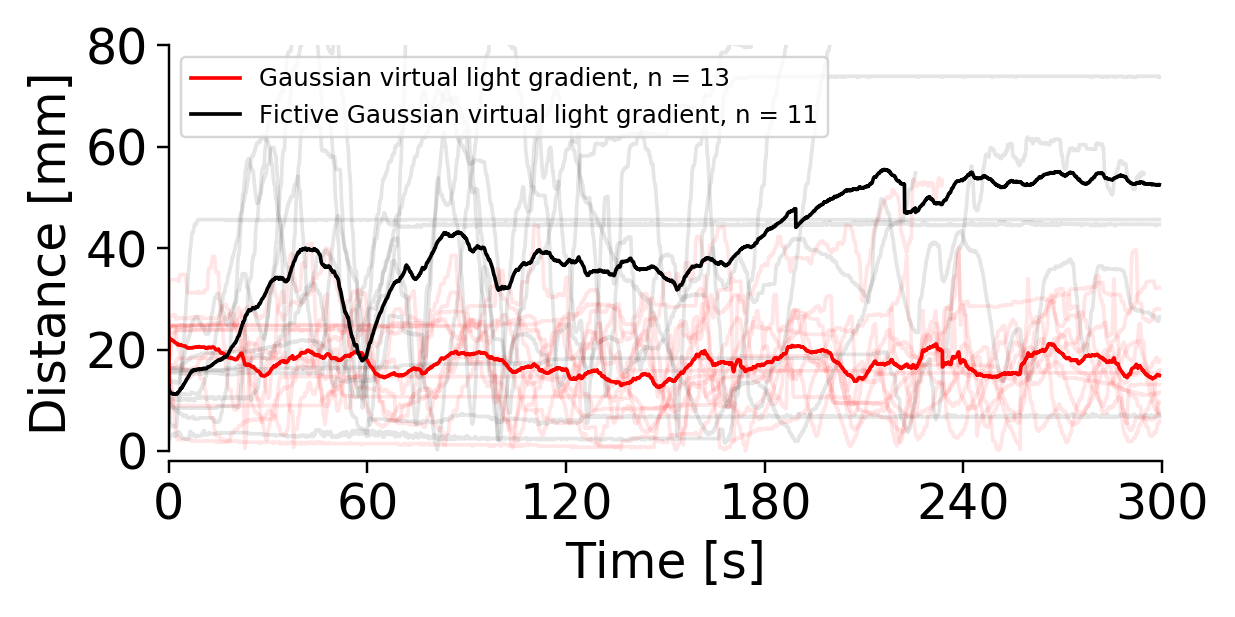

In [8]:
plot_distance_to_source(distance_exp[10::], distance_ctr[10::], fps)

<IPython.core.display.Javascript object>


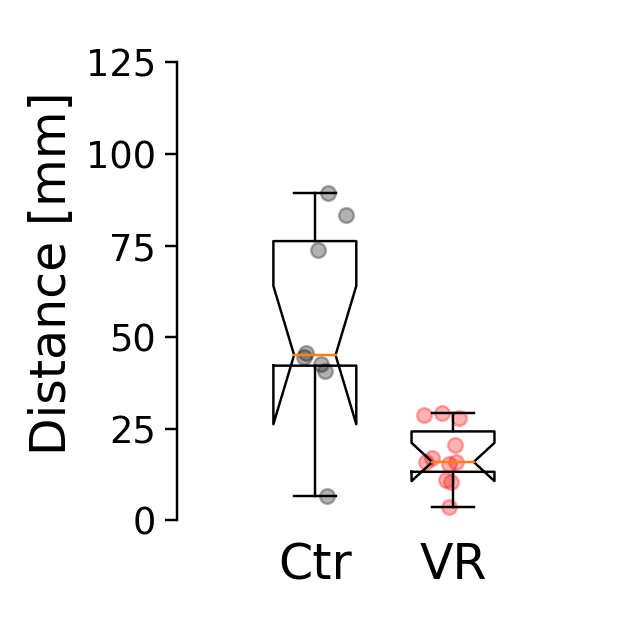


lilliefors exp: 0.2 lilliefors ctr: 0.2
LeveneResult(statistic=4.927577405163548, pvalue=0.04031948838249635)
RanksumsResult(statistic=-2.8074576010722194, pvalue=0.004993425270736)


In [9]:
# sup figure with indication of significance

timepoint = 240*30

# plot the distance to maximum in boxplot

positions = [0,0.25]

x = np.random.normal(positions[1], 0.03, size=distance_exp.shape[1])
x_ctr = np.random.normal(positions[0], 0.03, size=distance_ctr.shape[1])

fig = plt.figure(figsize=(3.5,3.5))
ax=fig.add_subplot(111)
ax.set_rasterization_zorder(1)
# plot gaussian
ax.scatter(x=x, y=distance_exp[timepoint,:], alpha=0.3, color='r', label='VR', zorder=0)
ax.boxplot(distance_exp[timepoint,~np.isnan(distance_exp[timepoint,:])], 
           positions=[positions[1]], showfliers=False, notch =True, zorder=1)
# plot control
ax.scatter(x=x_ctr, y=distance_ctr[timepoint,:], alpha=0.3, color='k', label='Ctr', zorder=0)
ax.boxplot(distance_ctr[timepoint,~np.isnan(distance_ctr[timepoint,:])], 
           positions=[positions[0]], showfliers=False, notch =True, zorder=1)

#ax.text(positions[0], 130, s='A', fontsize=20)
#ax.text(positions[1], 130, s='B', fontsize=20)

ax.set_xlim(-0.25,0.5)
ax.set_xticks(ticks=positions)
ax.set_ylim(0,135)

ax.set_xticklabels([ 'Ctr', 'VR'],
                  rotation=0, fontsize=20)

ax.tick_params(axis='y', labelsize=15)
ax.set_ylabel('Distance [mm]', fontsize=20)
#ax.grid(alpha=0.5, axis='y')

# get rid of ticks (bottom ticks)
ax.tick_params(
        #axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the left edge are off
        labelleft=True,   # labels along the left edge are off
        labelbottom=True
        ) 

# turn spines of everywhere except on the left
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# modify spines on the left
ax.spines['left'].set_bounds(0,125)
ax.spines['left'].set_linewidth(1)
# Change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', width=1, length =5)
ax.tick_params(axis='both', which='minor', width =1,length =3)

fig.tight_layout()
if save_plot:
    fig.savefig(Path(target_path, 'Fig4S8a.eps'), rasterized=True, dpi=300)

print("\nlilliefors exp: " + repr(sm.stats.lilliefors(distance_exp[timepoint,~np.isnan(distance_exp[timepoint,:])])[1]), 
     "lilliefors ctr: " + repr(sm.stats.lilliefors(distance_ctr[timepoint,~np.isnan(distance_ctr[timepoint,:])])[1])) 
print(stats.levene(distance_exp[timepoint,~np.isnan(distance_exp[timepoint,:])],
                   distance_ctr[timepoint,~np.isnan(distance_ctr[timepoint,:])]))
print(stats.ranksums(distance_exp[timepoint,~np.isnan(distance_exp[timepoint,:])],
                     distance_ctr[timepoint,~np.isnan(distance_ctr[timepoint,:])]))